# P値と信頼区間

* 黒木玄
* 2025-05-27
* このノートブックの内容の解説は[手書きのノート](https://github.com/genkuroki/Statistics/blob/master/2022/handwritten/%E6%95%B0%E7%90%86%E7%B5%B1%E8%A8%88%E5%AD%A608%20P%E5%80%A4%E3%81%A8%E4%BF%A1%E9%A0%BC%E5%8C%BA%E9%96%93%E3%81%A8%E3%81%AF%E4%BD%95%E3%81%8B.pdf)にある.
* このノートブックは[Google Colabで実行できる](https://colab.research.google.com/github/genkuroki/Statistics/blob/master/2022/handwritten/08_P-value_and_confidence_interval.ipynb).


P値と信頼区間に関する現代的な理解については

* [音声概要集](https://genkuroki.github.io/audio/)

の01番から06番の6つの音声概要を聴いて欲しい. 全部1倍速で聴いても1時間弱.

言葉ではなく, 数学的なP値と信頼区間の理解については, このノートブックのコードが役に立つだろう.

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

import Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

# 以下は黒木玄がよく使っているパッケージ達
# 例えばQuadGKパッケージ(数値積分のパッケージ)の使い方は
# QuadGK.jl をインターネットで検索すれば得られる.

ENV["LINES"], ENV["COLUMNS"] = 100, 100
using LinearAlgebra
using Printf
using Random
Random.seed!(4649373)

@autoadd begin
using Distributions
using StatsPlots
default(fmt=:png, legendfontsize=12)
#using BenchmarkTools
#using Optim
#using QuadGK
#using RDatasets
#using Roots
#using StatsBase
#using StatsFuns
#using SpecialFunctions
#using SymPy
end

In [2]:
safediv(x, y) = x == 0 ? zero(x/y) : x/y
r(x) = round(x; sigdigits=3)

r (generic function with 1 method)

In [3]:
surprisal_value(pval) = -log2(pval)

surprisal_value (generic function with 1 method)

In [4]:
@show surprisal_value(1.0);
@show surprisal_value(0.5);
@show surprisal_value(0.25);
@show surprisal_value(0.125);
@show surprisal_value(0.0625);
@show surprisal_value(0.03125);
@show surprisal_value(0.05) |> r;
@show surprisal_value(0.01) |> r;
@show surprisal_value(0.001) |> r;

surprisal_value(1.0) = -0.0
surprisal_value(0.5) = 1.0
surprisal_value(0.25) = 2.0
surprisal_value(0.125) = 3.0
surprisal_value(0.0625) = 4.0
surprisal_value(0.03125) = 5.0
surprisal_value(0.05) |> r = 4.32
surprisal_value(0.01) |> r = 6.64
surprisal_value(0.001) |> r = 9.97


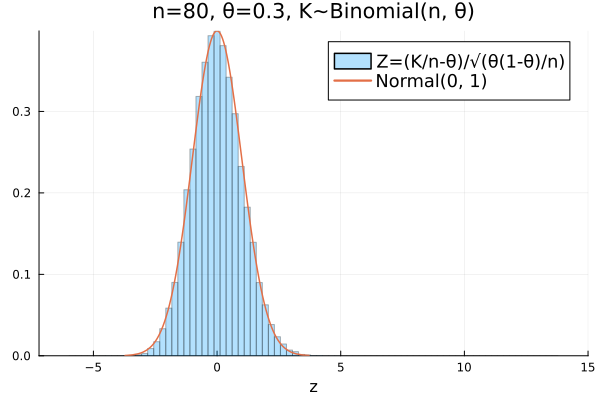

In [5]:
n, theta = 80, 0.3
L = 10^5
Z = zeros(L)
for i in 1:L
    K = rand(Binomial(n, theta))
    Z[i] = (K/n - theta) / sqrt(theta*(1-theta)/n)
end

Kbin = -0.5:n+0.5
Zbin = @. (Kbin/n - theta) / sqrt(theta*(1-theta)/n)
histogram(Z; norm=true, alpha=0.3, bin=Zbin, label="Z=(K/n-θ)/√(θ(1-θ)/n)")
plot!(Normal(0, 1); label="Normal(0, 1)", lw=1.5)
plot!(xguide="z")
title!("n=$n, θ=$theta, K~Binomial(n, θ)")

a = (k / n - theta) / sqrt((theta * (1 - theta)) / n) = 1.7999999999999994
pval = 2 * ccdf(Normal(0, 1), abs(a)) = 0.07186063822585168


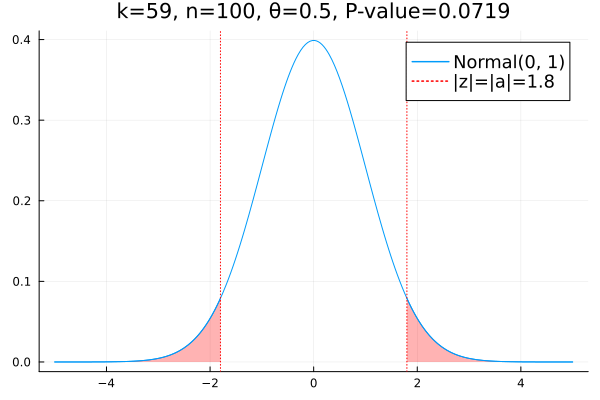

In [6]:
theta = 0.5
n = 100
k = 59
@show a = (k/n - theta) / sqrt(theta*(1-theta)/n)
@show pval = 2ccdf(Normal(0, 1), abs(a))

plot(Normal(0, 1), -5, 5; label="Normal(0, 1)", c=1)
plot!(Normal(0, 1), -5, -abs(a); label="", c=1, fillrange=0, fc=:red, fa=0.3)
plot!(Normal(0, 1), abs(a), 5; label="", c=1, fillrange=0, fc=:red, fa=0.3)
vline!([abs(a), -abs(a)]; label="|z|=|a|=$(r(abs(a)))", c=:red, ls=:dot)
title!("k=$k, n=$n, θ=$theta, P-value=$(r(pval))")

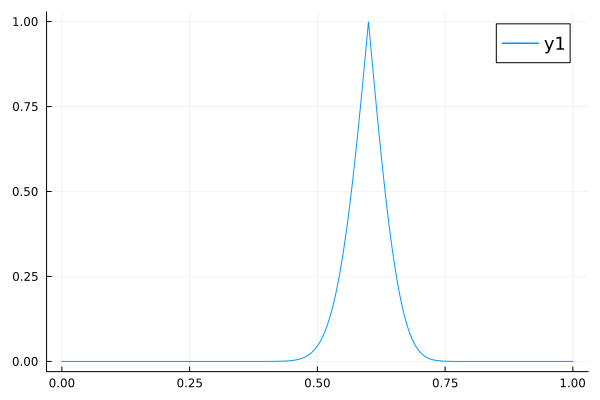

In [7]:
function pvalue_wilson(k, n, theta)
    z = safediv(k/n - theta, sqrt(theta*(1-theta)/n))
    2ccdf(Normal(0, 1), abs(z))
end

# 学習のためにはこういう素朴なプロットでも十分な場合が多い.
k, n = 60, 100
plot(theta -> pvalue_wilson(k, n, theta), 0, 1)

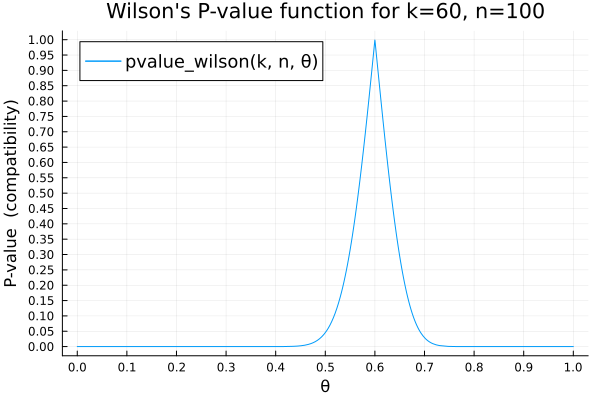

In [8]:
function plot_pvalue_wilson(k, n; c=1, kwargs...)
    plot(theta -> pvalue_wilson(k, n, theta), 0, 1; label="pvalue_wilson(k, n, θ)", c)
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    plot!(xguide="θ", yguide="P-value  (compatibility)")
    title!("Wilson's P-value function for k=$k, n=$n")
    plot!(; kwargs...)
end

plot_pvalue_wilson(60, 100; legend=:topleft)

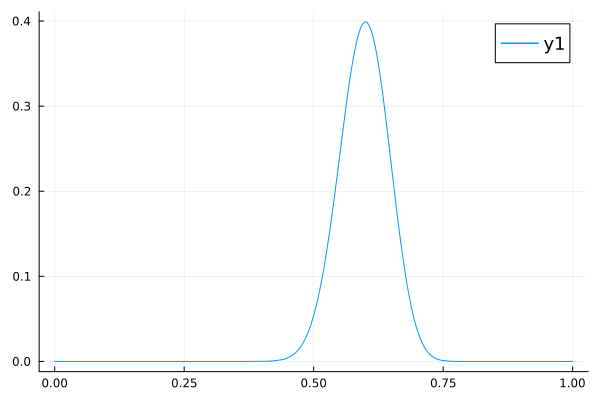

In [9]:
function likelihood_wilson(k, n, theta)
    z = safediv(k/n - theta, sqrt(theta*(1-theta)/n))
    pdf(Normal(0, 1), abs(z))
end

# 学習のためにはこういう素朴なプロットでも十分な場合が多い.
k, n = 60, 100
plot(theta -> likelihood_wilson(k, n, theta), 0, 1)

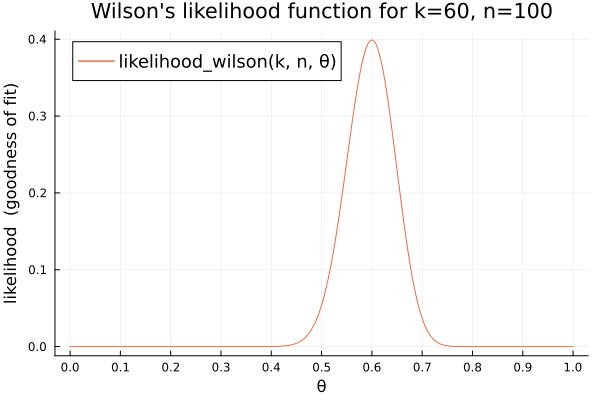

In [10]:
function plot_likelihood_wilson(k, n; c=2, kwargs...)
    plot(theta -> likelihood_wilson(k, n, theta), 0, 1; label="likelihood_wilson(k, n, θ)", c)
    plot!(xtick=0:0.1:1)
    plot!(xguide="θ", yguide="likelihood  (goodness of fit)")
    title!("Wilson's likelihood function for k=$k, n=$n")
    plot!(; kwargs...)
end

plot_likelihood_wilson(60, 100; legend=:topleft)

In [11]:
function plot_pvalue_likelihood_wilson(k, n; kwargs...)
    P = plot_pvalue_wilson(k, n; kwargs..., ytick=0:0.1:1)
    Q = plot_likelihood_wilson(k, n; kwargs...)
    plot(P, Q; size=(600, 600), layout=(2, 1))
end

plot_pvalue_likelihood_wilson (generic function with 1 method)

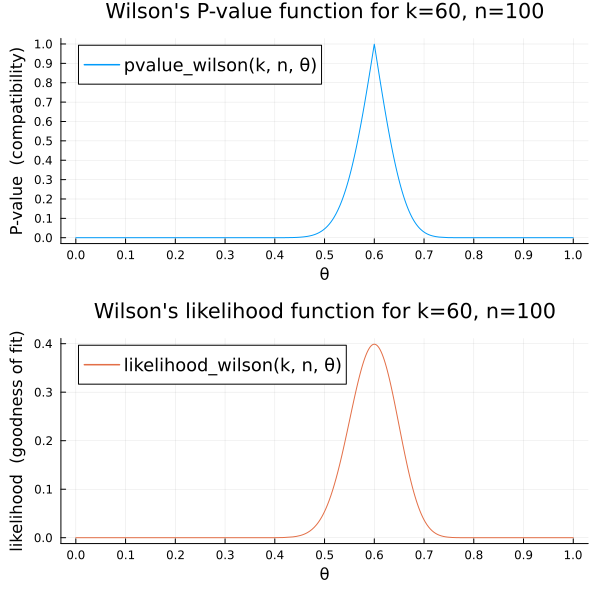

In [12]:
plot_pvalue_likelihood_wilson(60, 100; legend=:topleft)

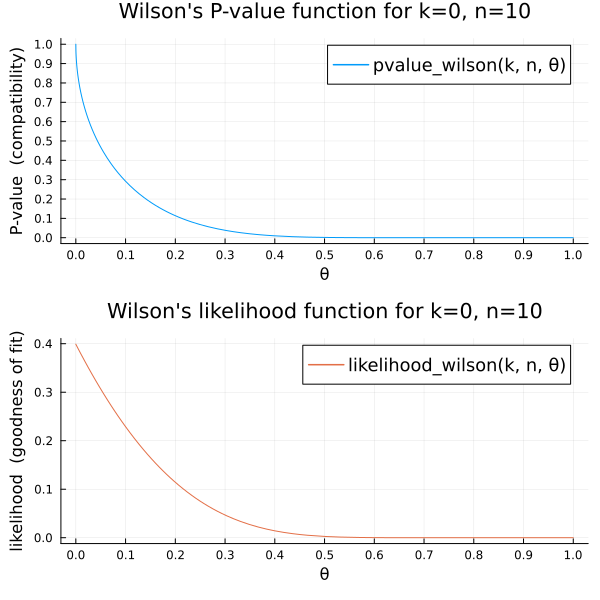

In [13]:
plot_pvalue_likelihood_wilson(0, 10)

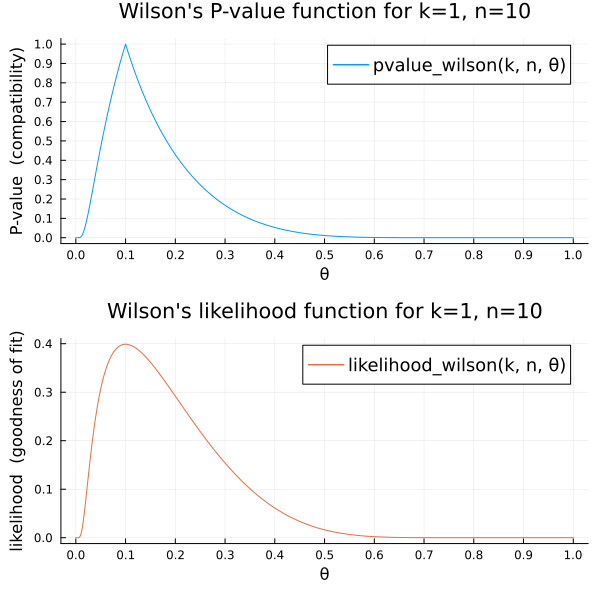

In [14]:
plot_pvalue_likelihood_wilson(1, 10)

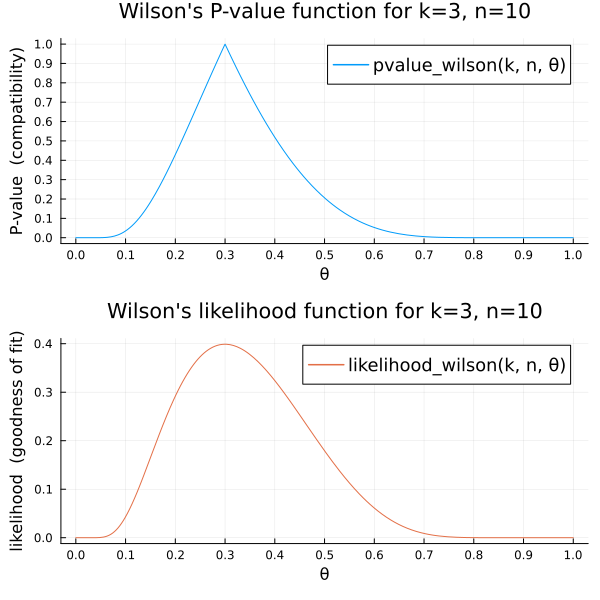

In [15]:
plot_pvalue_likelihood_wilson(3, 10)

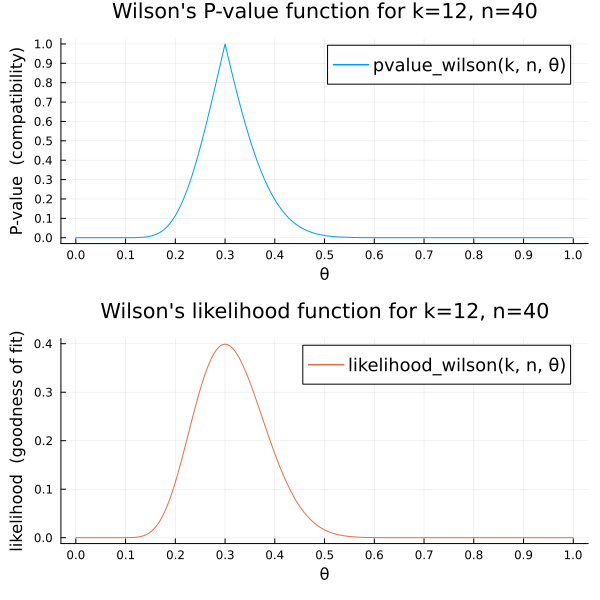

In [16]:
plot_pvalue_likelihood_wilson(12, 40)

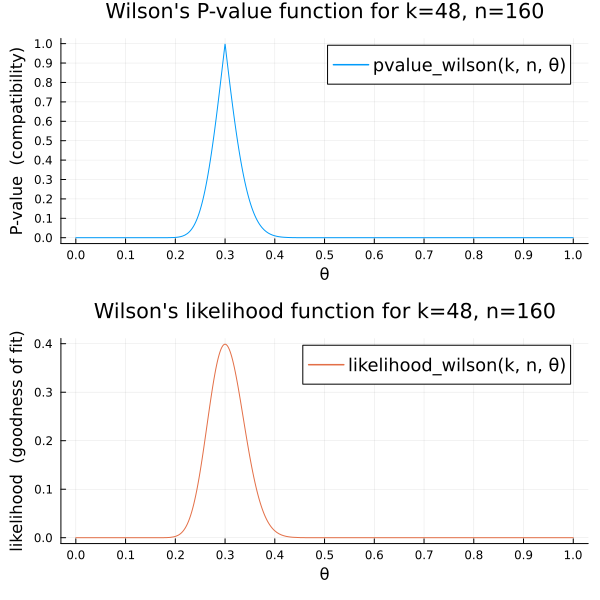

In [17]:
plot_pvalue_likelihood_wilson(48, 160)

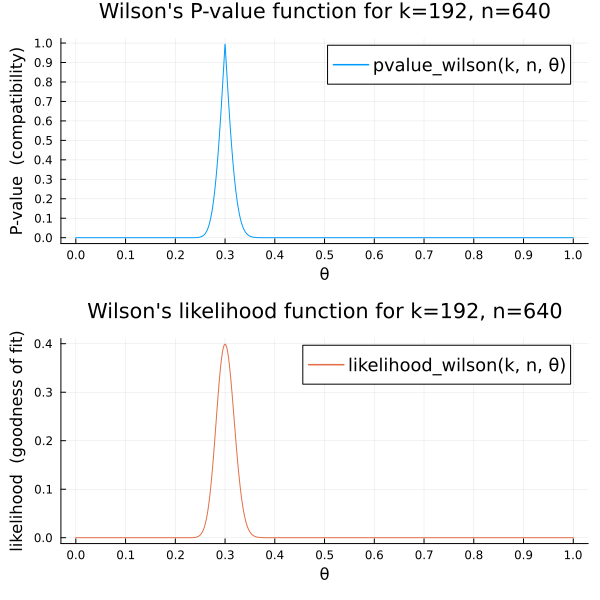

In [18]:
plot_pvalue_likelihood_wilson(192, 640)

In [19]:
@show cquantile(Normal(0, 1), 0.05/2);
@show cquantile(Normal(0, 1), 0.01/2);
@show cquantile(Normal(0, 1), 0.001/2);

cquantile(Normal(0, 1), 0.05 / 2) = 1.9599639845400592
cquantile(Normal(0, 1), 0.01 / 2) = 2.5758293035489053
cquantile(Normal(0, 1), 0.001 / 2) = 3.2905267314919


In [20]:
function confint_wilson(k, n, alpha=0.05)
    c = cquantile(Normal(0, 1), alpha/2)
    thetahat = k/n
    A, B, C = 1+c^2/n, thetahat+c^2/(2n), thetahat^2
    sqrtD = sqrt(B^2 - A*C)
    [(B - sqrtD)/A, (B + sqrtD)/A]
end

function plot_pvalue_confint_wilson(k, n, alpha=0.05; kwargs...)
    ci = confint_wilson(k, n, alpha)
    println("confint_wilson($k, $n, $alpha) ≈ ", r.(ci))
    plot_pvalue_wilson(k, n; c=1)
    plot!(ci, fill(alpha, 2); label="confint_wilson(k, n, α)", lw=2, c=2)
    title!("k=$k, n=$n, α=$alpha")
    plot!(; kwargs...)
end

plot_pvalue_confint_wilson (generic function with 2 methods)

confint_wilson(60, 100, 0.05) ≈ [0.502, 0.691]


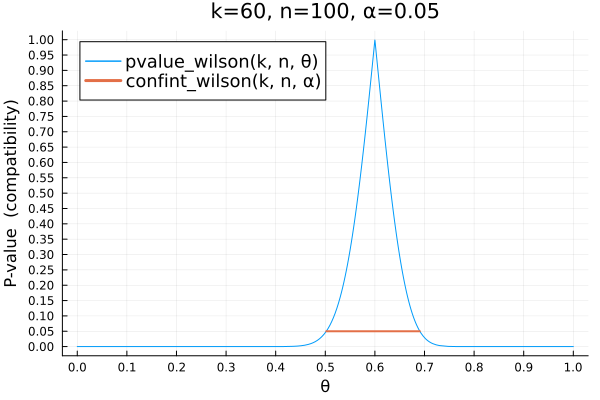

In [21]:
# 100(1-α)% 信頼区間はP値関数の高さ α での切断に過ぎない.
# 以下は α = 5% の場合である.

plot_pvalue_confint_wilson(60, 100; legend=:topleft, ytick=0:0.05:1)

confint_wilson(0, 10, 0.05) ≈ [0.0, 0.278]
confint_wilson(1, 10, 0.05) ≈ [0.0179, 0.404]
confint_wilson(2, 10, 0.05) ≈ [0.0567, 0.51]
confint_wilson(3, 10, 0.05) ≈ [0.108, 0.603]
confint_wilson(4, 10, 0.05) ≈ [0.168, 0.687]
confint_wilson(5, 10, 0.05) ≈ [0.237, 0.763]


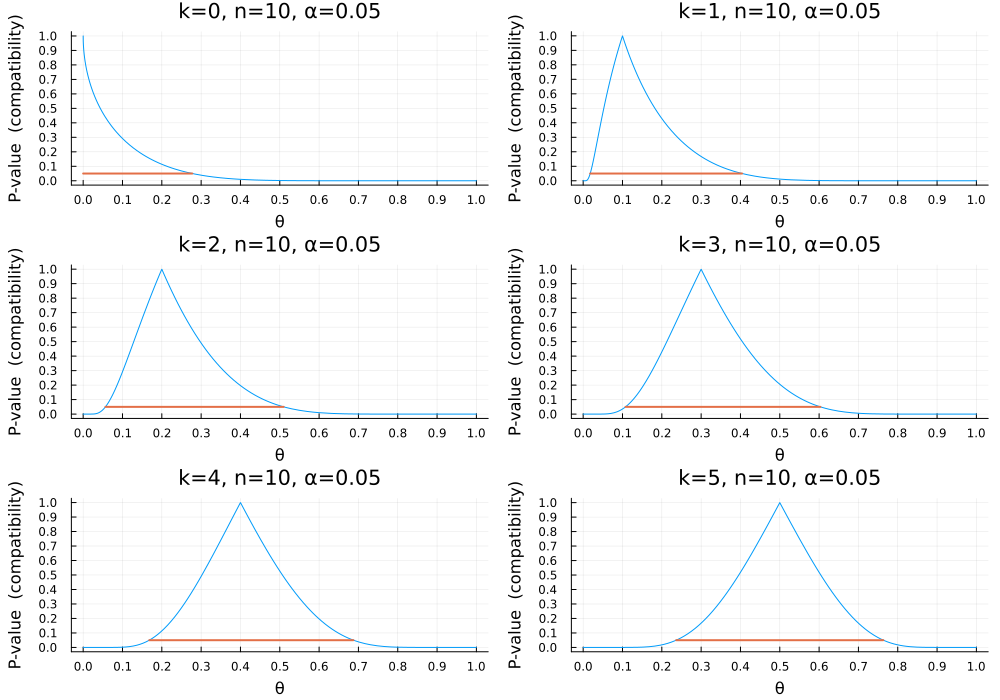

In [22]:
PP = []
for k in 0:5
    P = plot_pvalue_confint_wilson(k, 10; ytick=0:0.1:1, legend=false)
    push!(PP, P)
end
plot(PP...; size=(1000, 700), layout=(3, 2), leftmargin=4Plots.mm)

P値はその小ささが重要なのだが, P値関数のグラフではP値の小ささを判別し難い.

P値の代わりにS値(surprisal value)をプロットするとその問題が解消される.<br>
(S値を使うことの欠点はS値はP値と違ってよく知られていないことである.)

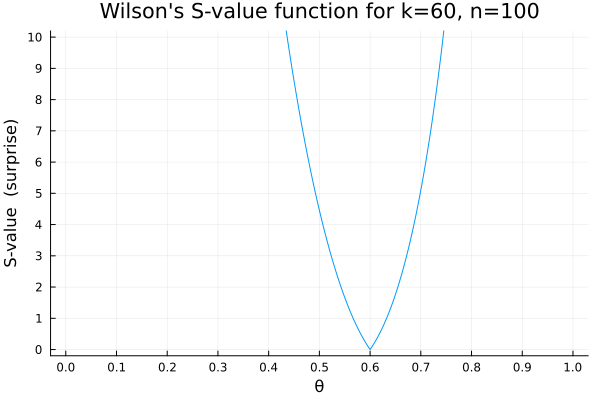

In [23]:
svalue_wilson(k, n, theta) = surprisal_value(pvalue_wilson(k, n, theta))

function plot_svalue_wilson(k, n; thetas=range(0, 1, 1001), c=1,
        ylim=(-0.2, 10.2), ytick=0:10, kwargs...)
    plot(thetas, theta -> svalue_wilson(k, n, theta); label="", c)
    plot!(; xtick=0:0.1:1, ytick)
    plot!(xguide="θ", yguide="S-value  (surprise)")
    plot!(; ylim)
    title!("Wilson's S-value function for k=$k, n=$n")
    plot!(; kwargs...)
end

plot_svalue_wilson(60, 100)

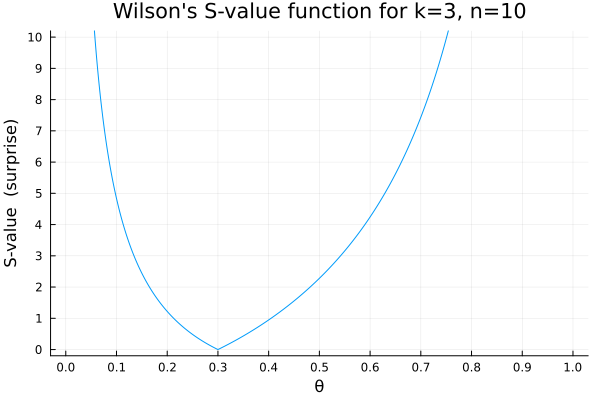

In [24]:
plot_svalue_wilson(3, 10)

In [25]:
function plot_svalue_confint_wilson(k, n, alpha=0.05; kwargs...)
    ci = confint_wilson(k, n, alpha)
    #println("confint_wilson($k, $n, $alpha) ≈ ", r.(ci))
    plot_svalue_wilson(k, n; c=1)
    plot!(ci, fill(surprisal_value(alpha), 2); label="", lw=2, c=2)
    title!("k=$k, n=$n, α=$alpha")
    plot!(; kwargs...)
end

plot_svalue_confint_wilson (generic function with 2 methods)

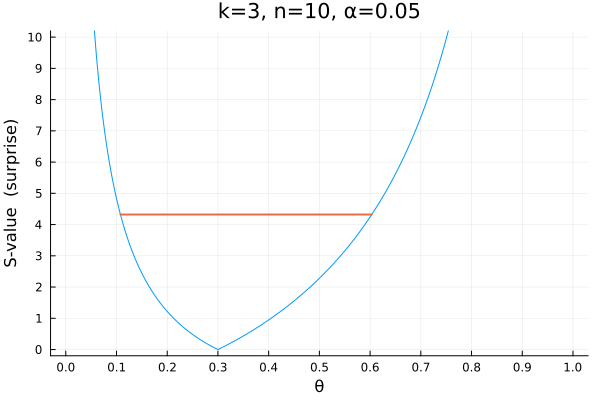

In [26]:
plot_svalue_confint_wilson(3, 10)

In [27]:
function plot_pvalue_svalue_confint_wilson(k, n, alpha=0.05; kwargs...)
    P = plot_pvalue_confint_wilson(k, n, alpha; kwargs..., ytick=0:0.1:1, legend=false)
    Q = plot_svalue_confint_wilson(k, n, alpha; kwargs...)
    plot(P, Q; size=(600, 600), layout=(2, 1))
end

plot_pvalue_svalue_confint_wilson (generic function with 2 methods)

confint_wilson(3, 10, 0.05) ≈ [0.108, 0.603]


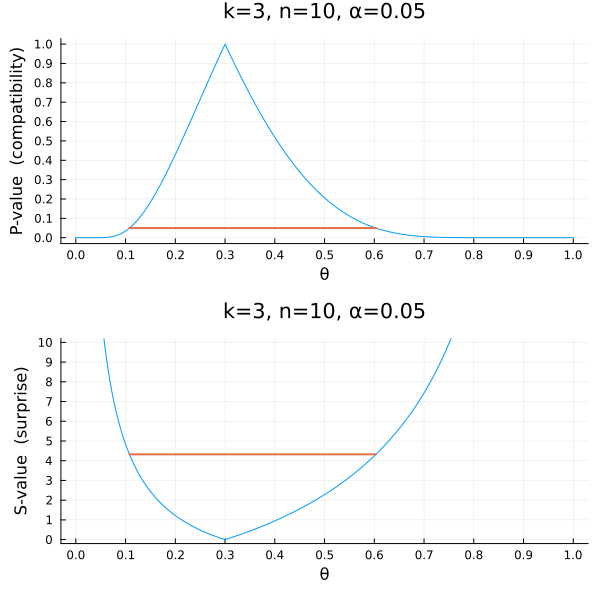

In [28]:
plot_pvalue_svalue_confint_wilson(3, 10)

confint_wilson(12, 40, 0.05) ≈ [0.181, 0.454]


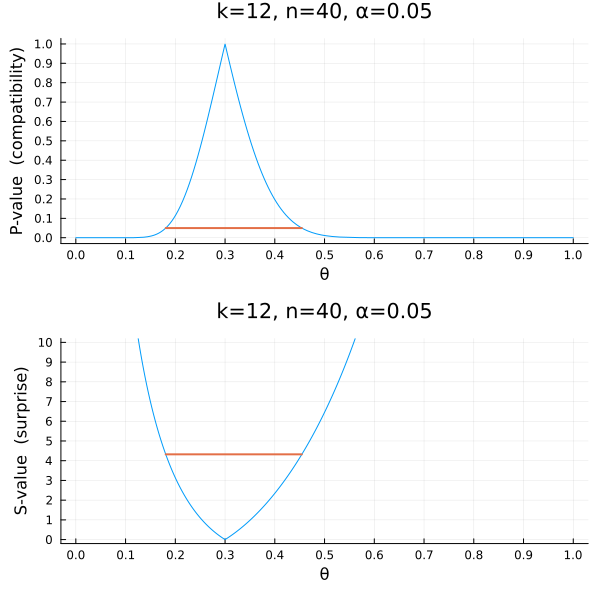

In [29]:
plot_pvalue_svalue_confint_wilson(12, 40)

confint_wilson(12, 40, 0.05) ≈ [0.181, 0.454]


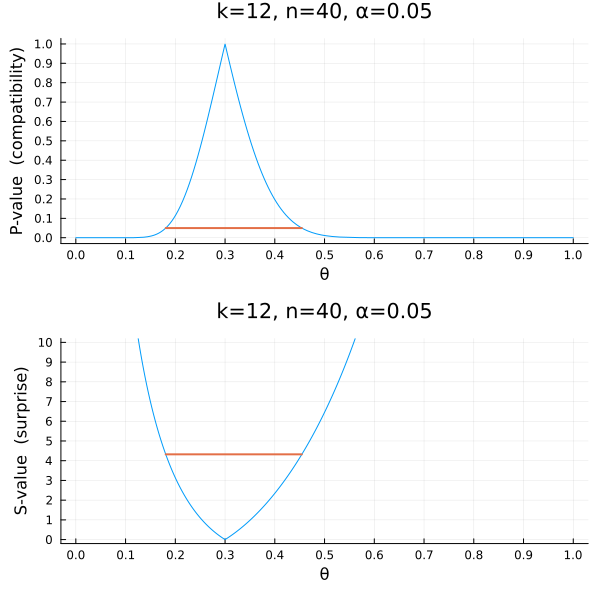

In [30]:
plot_pvalue_svalue_confint_wilson(12, 40)

confint_wilson(192, 640, 0.05) ≈ [0.266, 0.337]


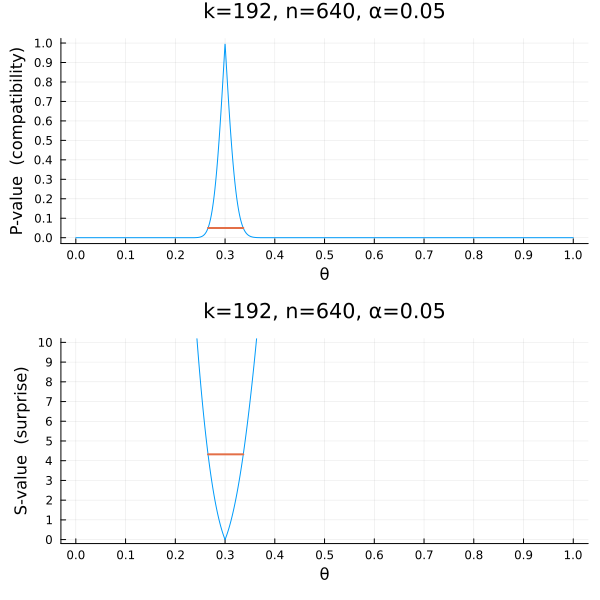

In [31]:
plot_pvalue_svalue_confint_wilson(192, 640)